<a href="https://colab.research.google.com/github/mimozairtem/mimozairtem.github.io/blob/master/2021_10_30_blog_post_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In Blog Post 5, we will focus on tensorflow datasets, data augmentation and transfer learning.

We will teach a machine learning algorithm how to distinguish between images of dogs and cats. 

First of all, we will import the necessary packages related to our blog post.

In [1]:
import os
import tensorflow as tf
from tensorflow.keras import utils, datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np

# Load Packages and Obtain Data

Now, we will create tensorflow datasets for training, validation, and testing. We have used `image_dataset_from_directory` function from the keras package for this purpose. We are getting the data from the directory but the data is in random order according to the parameter `shuffle` inside the function. The parameter `batch_size` tells us how many data points are collected from the directory, here we can say that 32 pictures are gathered from each data set. 

In [2]:
# location of data
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

# download the data and extract it
path_to_zip = utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)

# construct paths
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

# parameters for datasets
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

# construct train and validation datasets 
train_dataset = utils.image_dataset_from_directory(train_dir,
                                                   shuffle=True,
                                                   batch_size=BATCH_SIZE,
                                                   image_size=IMG_SIZE)

validation_dataset = utils.image_dataset_from_directory(validation_dir,
                                                        shuffle=True,
                                                        batch_size=BATCH_SIZE,
                                                        image_size=IMG_SIZE)

# construct the test dataset by taking every 5th observation out of the validation dataset
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


### Working with Datasets- Function

We will create a function called `visual_plot`

In [3]:
def visual_plot(train_dataset):
  class_names = train_dataset.class_names
  image = []
  label = []

#take one batch from the train_dataset
  for images, labels in train_dataset.take(1):
    image.append(images)
    label.append(labels)


#loop over the images and append the image to 
#the corresponding element, either cats or dogs
  cats = []
  dogs = []
  for i in range(len(images)):
    temp = [0, 0]
    temp[0] = image[0][i].numpy().astype("uint8")
    temp[1] = class_names[label[0][i]]
    #append to list dogs
    if temp[1] == 'dogs' and len(dogs) < 3:
      dogs.append(temp)
    #append to list cats
    elif temp[1] == 'cats' and len(cats) < 3:
      cats.append(temp)

    if len(dogs) == 3 and len(cats) == 3:
      break

  #first row cats
  plt.figure(figsize=(10, 10))
  for i in range(len(cats)):
      plt.subplot(2,3,i+1)
      plt.imshow(cats[i][0])
      plt.title(cats[i][1])
      plt.axis("off")
  #second row dogs
  for i in range(len(dogs)):
      plt.subplot(2,3,i+4)
      plt.imshow(dogs[i][0])
      plt.title(dogs[i][1])
      plt.axis("off")

  plt.show()

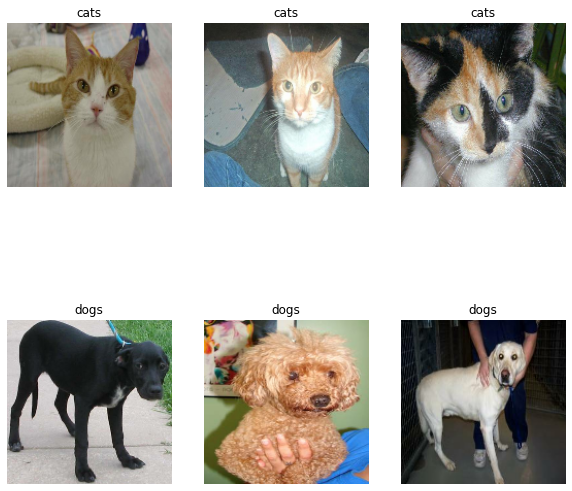

In [4]:
visual_plot(train_dataset)

In [13]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)


### Check Label Frequencies

In [14]:
labels_iterator= train_dataset.unbatch().map(lambda image, label: label).as_numpy_iterator()


Here, we are creating a iterater called labels to compute the number of images in the training data. The iterater will help us identify that "0" corresponds to `cats` and "1" corresponds to `dogs`.

In [23]:
for labels in train_dataset.take(1):
  print(len(labels[1]))

32


Here we can see that the total number of dogs and cats are 32.

In [26]:
count = np.count_nonzero(labels[1] == 0)
print('Total occurences of cats in array: ', count)

Total occurences of cats in array:  15


In [27]:
count = np.count_nonzero(labels[1] == 1)
print('Total occurences of dogs in array: ', count)

Total occurences of dogs in array:  17


According to the training data, there are 15 images of cats and 17 images of dogs in one batch of the training data.

# First Model

Here, we will create a `tf.keras.Sequential` model using different layers. 

In [28]:
model1 = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(160, 160, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(2),
])

In [29]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 158, 158, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 79, 79, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 77, 77, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 38, 38, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 36, 36, 64)        18496     
                                                                 
 dropout (Dropout)           (None, 36, 36, 64)        0

In [30]:
model1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model1.fit(train_dataset, 
                     epochs=20, 
                     validation_data=validation_dataset)

Epoch 1/20
63/63 [==============================] - 29s 85ms/step - loss: 15.5161 - accuracy: 0.5305 - val_loss: 0.6964 - val_accuracy: 0.5000
Epoch 2/20
63/63 [==============================] - 5s 79ms/step - loss: 0.6435 - accuracy: 0.5820 - val_loss: 0.7162 - val_accuracy: 0.5136
Epoch 3/20
63/63 [==============================] - 5s 76ms/step - loss: 0.5842 - accuracy: 0.6355 - val_loss: 0.7883 - val_accuracy: 0.5557
Epoch 4/20


KeyboardInterrupt: ignored

In [ ]:
plt.plot(history.history["accuracy"], label = "training")
plt.plot(history.history["val_accuracy"], label = "validation")
plt.gca().set(xlabel = "epoch", ylabel = "accuracy")
plt.legend()

**The accuracy of my model stabilized between 56% and 62% during training.**

Overfitting can be observed in `model1`because the training accuracy is much higheer than the validationa accuracy.

# Model with Data Augmentation

Here, we will add data augmentation layers to our model. This means that we are adding tranformations to the training images. For example, we changing the angle an image is shown in the dataset. 

We will create a `tf.keras.layers.RandomFlip()` layer to perform the data augmentation. 

### Random Flip:

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('vertical')
])

In [ ]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

### Random Rotation

In [ ]:
data_augmentation = tf.keras.Sequential([
 tf.keras.layers.RandomRotation(0.3)
])

In [ ]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

#### Model 2:

In [ ]:
model2 = models.Sequential([
    layers.RandomRotation(0.3, input_shape=(160, 160, 3)),
    layers.RandomFlip('vertical'),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(2),
])

In [ ]:
model2.summary()

In [ ]:
model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model2.fit(train_dataset, 
                     epochs=20, 
                     validation_data=validation_dataset)

In [ ]:
plt.plot(history.history["accuracy"], label = "training")
plt.plot(history.history["val_accuracy"], label = "validation")
plt.gca().set(xlabel = "epoch", ylabel = "accuracy")
plt.legend()

**The accuracy of model2 stabilized between 63% and 66% during training.**

The validation accuracy of model2 is higher than model1. 

The training accuracy is similar to the validation accuracy, therefore, we do not observe overfitting.

# Data Preprocessing

Here, we will create another layer called `preprocessor` which will scale the weights of our data prior to the training process. Therefore, we will not need to spend more energy on scaling the data.

In [ ]:
i = tf.keras.Input(shape=(160, 160, 3))
x = tf.keras.applications.mobilenet_v2.preprocess_input(i)
preprocessor = tf.keras.Model(inputs = [i], outputs = [x])

In [ ]:
model3 = models.Sequential([
    preprocessor,                      
    layers.RandomRotation(0.3, input_shape=(160, 160, 3)),
    layers.RandomFlip('vertical'),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(2),
])

In [ ]:
model3.summary()

In [ ]:
model3.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model3.fit(train_dataset, 
                     epochs=20, 
                     validation_data=validation_dataset)

In [ ]:
plt.plot(history.history["accuracy"], label = "training")
plt.plot(history.history["val_accuracy"], label = "validation")
plt.gca().set(xlabel = "epoch", ylabel = "accuracy")
plt.legend()

**The accuracy of model3 stabilized between 69% and 71%.**

The validation accuracy of model3 is much higher than what we were able to obtain with model2. 

The training accuracy is similar to the validation accuracy, therefore, we do not observe overfitting.

# Transfer Learning

Here, we will create another model in order to use a pre-existing model for our task. We will access a pre-existing "base model", use it in our task and train that model.

In [ ]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False

i = tf.keras.Input(shape=IMG_SHAPE)
x = base_model(i, training = False)
base_model_layer = tf.keras.Model(inputs = [i], outputs = [x])


In [ ]:
model4 = models.Sequential([                    
    preprocessor,                      
    layers.RandomRotation(0.3, input_shape=(160, 160, 3)),
    layers.RandomFlip('vertical'),
    base_model_layer,
    layers.GlobalMaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(2),
])

In [ ]:
model4.summary()

In [ ]:
model4.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model4.fit(train_dataset, 
                     epochs=20, 
                     validation_data=validation_dataset)

In [ ]:
plt.plot(history.history["accuracy"], label = "training")
plt.plot(history.history["val_accuracy"], label = "validation")
plt.gca().set(xlabel = "epoch", ylabel = "accuracy")
plt.legend()

**The accuracy of model4 stabilized between 95% and 97%.**

The validation accuracy of model4 is much higher than what we were able to obtain with model3.



The training accuracy is similar to the validation accuracy, therefore, we do not observe overfitting.

# Score on Test Data

In [ ]:
loss, accuracy = model4.evaluate(test_dataset)
print('Test accuracy :', accuracy)

The training accuracy is nearly the same as the test accuracy.